# SAM processing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from Helpers import show_masks_fixed, visualize_masks, load_and_crop_data


train_img_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/meatballs/images/train/frame_000000.PNG"
train_label_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/meatballs/labels/train/frame_000000.txt"

# Define crop coordinates (y_start, y_end, x_start, x_end)
crop_coords = (30, 300, 200, 450)

# Load and crop both image and masks
train_img, train_masks_gt = load_and_crop_data(train_img_path, train_label_path, crop_coords)

# Verify dimensions
print(f"Cropped image shape: {train_img.shape}")
print(f"Cropped mask shape: {train_masks_gt[0].shape}")

# Visualize
visualize_masks(train_img, train_masks_gt)

ModuleNotFoundError: No module named 'Helpers'

Cropped image shape: (270, 250, 3)
Cropped mask shape: (270, 250)


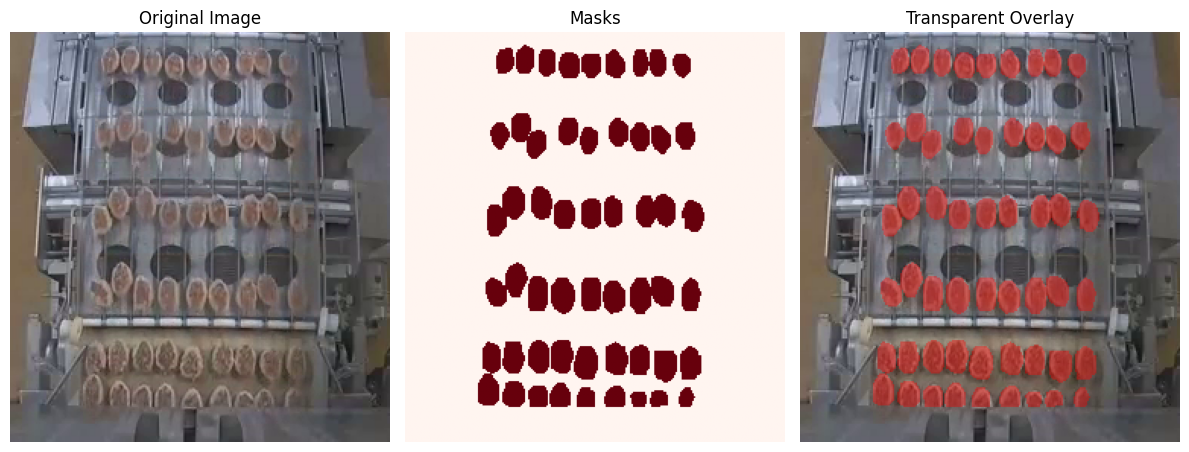

In [ ]:
test_img_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/meatballs/images/train/frame_002388.PNG"
test_label_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/meatballs/labels/train/frame_002388.txt"

test_img, test_masks_gt = load_and_crop_data(test_img_path, test_label_path, crop_coords)

print(f"Cropped image shape: {train_img.shape}")
print(f"Cropped mask shape: {train_masks_gt[0].shape}")

visualize_masks(test_img, test_masks_gt)

In [ ]:
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.build_sam import build_sam2
from sam2.utils.misc import variant_to_config_mapping

model = build_sam2(
    variant_to_config_mapping["small"],
    "../models/sam2_hiera_small.pt",
)

mask_generator = SAM2AutomaticMaskGenerator(
    model,
    points_per_side=32,           # Increased from default 32
    pred_iou_thresh=0.7,          # Lowered from default 0.8
    stability_score_thresh=0.85,  # Lowered from default 0.95
    box_nms_thresh=0.6,           # Lowered from default 0.7
    )


In [5]:
test_masks = mask_generator.generate(test_img)

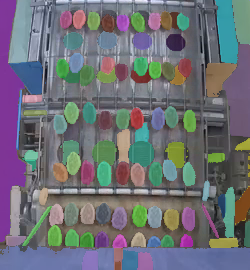

In [6]:
test_output_mask = show_masks_fixed(image = test_img, masks = test_masks, scores=None, only_best=False, autogenerated_mask=True)

test_output_mask

In [7]:
test_full_seg = []

for  mask in test_masks:
    bi_mask = mask["segmentation"]
    test_full_seg.append(bi_mask)

# CLIP

In [2]:
import torch
import clip
import numpy as np
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms


class CLIPFeatureSimilarity:
    def __init__(self, clip_model="ViT-B/32", similarity_threshold=0.8, device=None):
        """
        Initialize a CLIP-based feature extractor for similarity-based auto-labeling
        
        Args:
            clip_model: CLIP model variant to use ("ViT-B/32", "ViT-B/16", etc.)
            similarity_threshold: Threshold for considering a region as matching the reference
            device: Device to run inference on (will use CUDA if available by default)
        """
        # Set up device
        if device is None:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device = device
            
        print(f"Using device: {self.device}")
        
        # Load the CLIP model
        self.model, self.preprocess = clip.load(clip_model, device=self.device)
        
        # We don't need to train the model
        self.model.eval()
        
        # Set the similarity threshold
        self.similarity_threshold = similarity_threshold
        
        # Store reference embeddings
        self.reference_embeddings = []
        self.reference_centroid = None
        
        # Define a basic transform to use when we're extracting with masks
        # This will be used after applying the mask, then we'll apply CLIP's preprocess
        self.basic_transform = transforms.Compose([
            transforms.ToTensor(),
        ])
    
    def extract_features(self, image, mask):
        """
        Extract CLIP features from a masked region of an image
        
        Args:
            image: PIL Image or numpy array
            mask: Binary mask indicating the region of interest (numpy array)
            
        Returns:
            features: Normalized feature vector from CLIP
        """
        # Convert image to PIL if it's numpy
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image.astype(np.uint8))
        
        # Ensure mask is numpy
        if not isinstance(mask, np.ndarray):
            mask = np.array(mask)
        
        # Find bounding box of the mask
        if mask.sum() > 0:  # Only if mask has positive pixels
            rows = np.any(mask, axis=1)
            cols = np.any(mask, axis=0)
            y_min, y_max = np.where(rows)[0][[0, -1]]
            x_min, x_max = np.where(cols)[0][[0, -1]]
            
            # Add padding to ensure the object is fully captured
            padding = 10
            y_min = max(0, y_min - padding)
            y_max = min(mask.shape[0], y_max + padding)
            x_min = max(0, x_min - padding)
            x_max = min(mask.shape[1], x_max + padding)
            
            # Check if the bounding box is valid
            if x_max <= x_min or y_max <= y_min:
                # Invalid bounding box, use the entire image
                image_array = np.array(image)
                # Apply mask to the image if dimensions allow
                if len(image_array.shape) == 3 and image_array.shape[:2] == mask.shape:
                    mask_3d = np.expand_dims(mask, axis=2).repeat(3, axis=2)
                    masked_image = image_array * mask_3d
                else:
                    # If dimensions don't match, just use the original image
                    masked_image = image_array
            else:
                # Crop the image and mask to the bounding box
                image_array = np.array(image)
                
                # Handle different image formats
                if len(image_array.shape) == 3:  # RGB image
                    cropped_image = image_array[y_min:y_max, x_min:x_max, :]
                    cropped_mask = mask[y_min:y_max, x_min:x_max]
                    # Expand mask to match image channels
                    mask_3d = np.expand_dims(cropped_mask, axis=2).repeat(3, axis=2)
                    masked_image = cropped_image * mask_3d
                else:  # Grayscale image
                    cropped_image = image_array[y_min:y_max, x_min:x_max]
                    cropped_mask = mask[y_min:y_max, x_min:x_max]
                    masked_image = cropped_image * cropped_mask
                
                # Check if mask actually removed content - if it's all zeros, use the cropped image
                if np.sum(masked_image) < 10:  # Arbitrary small threshold
                    masked_image = cropped_image
        else:
            # Empty mask, use original image
            masked_image = np.array(image)
        
        # Convert back to PIL Image
        masked_image = Image.fromarray(masked_image.astype(np.uint8))
        
        # Apply CLIP's preprocessing
        input_tensor = self.preprocess(masked_image).unsqueeze(0).to(self.device)
        
        # Extract features using CLIP
        with torch.no_grad():
            features = self.model.encode_image(input_tensor)
            
        # Normalize features
        features = F.normalize(features, dim=-1)
        
        return features.cpu().numpy()[0]  # Return as numpy array
    
    def fit(self, images, masks):
        """
        Extract and store reference features from positive examples
        
        Args:
            images: List of images or a single image
            masks: List of masks or a single mask
            
        Returns:
            bool: Success or failure
        """
        self.reference_embeddings = []
        
        # Convert single image to list for consistent processing
        if not isinstance(images, list):
            images = [images]
        
        # Convert single mask to list for consistent processing
        if not isinstance(masks, list):
            masks = [masks]
        
        # Process each image and its corresponding mask(s)
        for i in range(len(images)):
            image = images[i]
            
            # Handle case where we have one image but multiple masks
            if len(masks) > len(images) and i == 0:
                image_masks = masks
                
                # Process each mask for this image
                for mask in image_masks:
                    try:
                        feature = self.extract_features(image, mask)
                        self.reference_embeddings.append(feature)
                    except Exception as e:
                        print(f"Error processing mask: {e}")
            # Handle case where masks[i] is a list of masks for image[i]
            elif i < len(masks) and isinstance(masks[i], list):
                image_masks = masks[i]
                
                # Process each mask for this image
                for mask in image_masks:
                    try:
                        feature = self.extract_features(image, mask)
                        self.reference_embeddings.append(feature)
                    except Exception as e:
                        print(f"Error processing mask: {e}")
            elif i < len(masks):
                # Single mask for this image
                mask = masks[i]
                
                # Extract features
                try:
                    feature = self.extract_features(image, mask)
                    self.reference_embeddings.append(feature)
                except Exception as e:
                    print(f"Error processing mask: {e}")
        
        # Compute centroid of reference embeddings (if any)
        if self.reference_embeddings:
            self.reference_embeddings = np.array(self.reference_embeddings)
            self.reference_centroid = np.mean(self.reference_embeddings, axis=0)
            self.reference_centroid = self.reference_centroid / np.linalg.norm(self.reference_centroid)
            print(f"Created reference with {len(self.reference_embeddings)} examples")
            return True
        else:
            print("No valid reference features extracted")
            return False
    
    def predict(self, image, candidate_masks, threshold=None, return_similarities=True):
        """
        Predict which candidate masks match the reference features
        
        Args:
            image: Input image
            candidate_masks: List of candidate segmentation masks
            threshold: Optional override for the similarity threshold
            return_similarities: Whether to return similarity scores
            
        Returns:
            filtered_masks: List of masks classified as matching
            similarities: (Optional) Similarity scores for each filtered mask
        """
        if threshold is None:
            threshold = self.similarity_threshold
            
        if not candidate_masks or len(candidate_masks) == 0:
            if return_similarities:
                return [], []
            else:
                return []
        
        # Check if we have reference features
        if self.reference_centroid is None:
            print("No reference features available. Call fit() first.")
            if return_similarities:
                return [], []
            else:
                return []
        
        # Extract features for all candidate masks
        candidate_features = []
        valid_masks = []
        
        for mask in candidate_masks:
            try:
                feature = self.extract_features(image, mask)
                candidate_features.append(feature)
                valid_masks.append(mask)
            except Exception as e:
                print(f"Error extracting features: {e}")
        
        if not candidate_features:
            if return_similarities:
                return [], []
            else:
                return []
        
        # Compare each candidate to the reference centroid
        similarities = []
        filtered_masks = []
        
        for i, feature in enumerate(candidate_features):
            # Compute cosine similarity
            similarity = np.dot(feature, self.reference_centroid)
            
            # Apply threshold
            if similarity >= threshold:
                filtered_masks.append(valid_masks[i])
                similarities.append(float(similarity))  # Convert to Python float for JSON serialization
        
        # Sort by similarity (highest first)
        if filtered_masks:
            sorted_indices = np.argsort(similarities)[::-1]
            filtered_masks = [filtered_masks[i] for i in sorted_indices]
            similarities = [similarities[i] for i in sorted_indices]
        
        if return_similarities:
            return filtered_masks, similarities
        else:
            return filtered_masks

ModuleNotFoundError: No module named 'clip'

In [8]:
model = CLIPFeatureSimilarity(
    clip_model="ViT-B/32", 
    similarity_threshold=0.8
)



Using device: cpu


100%|████████████████████████████████████████| 338M/338M [07:49<00:00, 753kiB/s]


In [ ]:
import random

random.seed(42)

train_subset = random.sample(train_masks_gt, 5)

model.fit(train_img, train_subset)

Created reference with 5 examples


True

In [10]:
filtered_masks, similarities = model.predict(
        test_img, 
        test_full_seg,
        return_similarities=True
    )

In [17]:
import sys
import os

# Get the absolute path to the repo root (parent of both src and notebook folders)
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the repo root to the Python path
sys.path.append(repo_root)

from src.master.visualize import visualize_masks
from src.master.evaluate import evaluate_binary_masks

In [13]:
print(len(test_full_seg))
print(len(filtered_masks))


104
103


In [14]:
def sort_masks(filtered_masks, filtered_probs):
    # Create pairs of (mask, score)
    mask_score_pairs = list(zip(filtered_masks, filtered_probs))

    # Sort the pairs based on scores in descending order (highest score first)
    sorted_pairs = sorted(mask_score_pairs, key=lambda x: x[1], reverse=True)

    # Unzip the sorted pairs
    sorted_masks, sorted_probs = zip(*sorted_pairs) if sorted_pairs else ([], [])

    # Convert back to lists if needed
    sorted_masks = list(sorted_masks)
    sorted_probs = list(sorted_probs)

    return sorted_masks, sorted_probs

In [15]:
sorted_masks, sorted_similarities = sort_masks(filtered_masks, similarities)

print(sorted_similarities)

[0.9856447577476501, 0.9848729372024536, 0.9841618537902832, 0.9836951494216919, 0.983481228351593, 0.9829050302505493, 0.9823492765426636, 0.9817625284194946, 0.9811568260192871, 0.9797928333282471, 0.9794726371765137, 0.9793334603309631, 0.9791796803474426, 0.978975772857666, 0.9774900674819946, 0.9773969650268555, 0.9772413969039917, 0.9765376448631287, 0.9755697846412659, 0.9752464890480042, 0.9748828411102295, 0.9743216633796692, 0.9739302396774292, 0.973000705242157, 0.9728710651397705, 0.9728484749794006, 0.9725174903869629, 0.9709079265594482, 0.9698428511619568, 0.9693831205368042, 0.9689491987228394, 0.9686586856842041, 0.9676021337509155, 0.9670645594596863, 0.966730535030365, 0.9666982293128967, 0.965041995048523, 0.9647893309593201, 0.9646472930908203, 0.9641635417938232, 0.9641334414482117, 0.9640880823135376, 0.9640743732452393, 0.9623939990997314, 0.9621805548667908, 0.9611496925354004, 0.960533618927002, 0.9603317975997925, 0.9580764770507812, 0.9572332501411438, 0.956

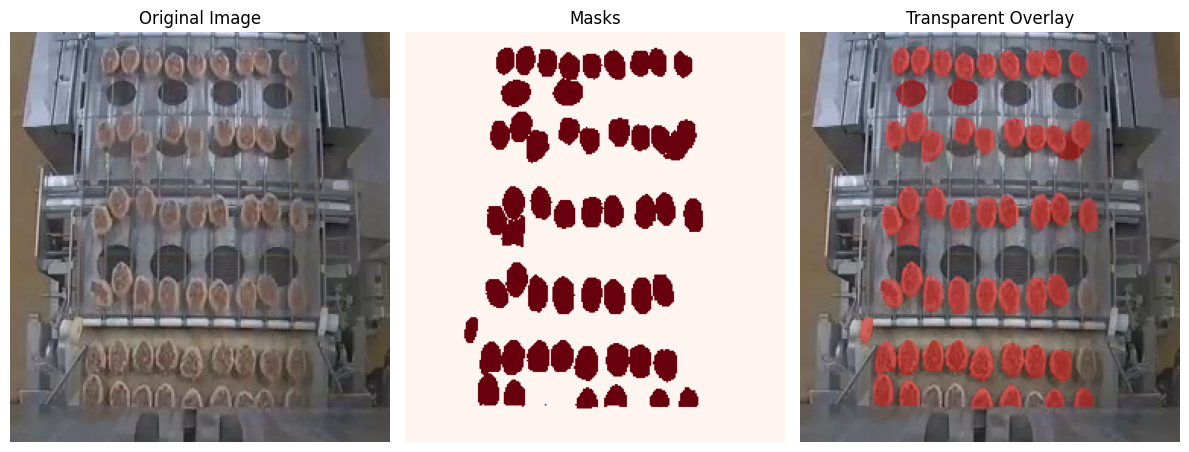

In [16]:
visualize_masks(test_img, sorted_masks[:54])

In [20]:
results = evaluate_binary_masks(test_masks_gt, sorted_masks[:60])

print(f"Mask Detection Rate (Recall): {results['mask_recall']:.4f}")
print(f"Mask Precision: {results['mask_precision']:.4f}")
print(f"Detected {results['detected_masks']} out of {results['total_gt_masks']} GT masks")
print(f"Average IoU of detected masks: {results['avg_iou_detected']:.4f}")

Mask Detection Rate (Recall): 0.9444
Mask Precision: 0.8500
Detected 51 out of 54 GT masks
Average IoU of detected masks: 0.8710


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_precision_recall_curve(test_masks_gt, all_masks, sorted_similarities):
    """
    Plot a precision-recall curve by evaluating masks at different similarity thresholds.
    
    Parameters:
    -----------
    test_masks_gt : list
        List of ground truth mask arrays
    all_masks : list
        List of all predicted mask arrays (should be in the same order as sorted_similarities)
    sorted_similarities : list
        Sorted list of similarity scores for each predicted mask
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure containing the precision-recall curve
    """
    # Get unique similarity values to use as thresholds
    # Add a value slightly higher than max to ensure we include the point (0,1)
    unique_thresholds = np.unique(sorted_similarities)
    thresholds = np.append(unique_thresholds, max(sorted_similarities) + 0.01)
    thresholds = np.sort(thresholds)
    
    # Initialize lists to store precision and recall values
    precisions = []
    recalls = []
    
    # Evaluate masks at each threshold
    for threshold in thresholds:
        # Get masks with similarity above threshold
        selected_masks = [all_masks[i] for i in range(len(sorted_similarities)) 
                         if sorted_similarities[i] >= threshold]
        
        # If no masks selected, precision is 0
        if len(selected_masks) == 0:
            precisions.append(0)
            recalls.append(0)
            continue
        
        # Evaluate selected masks
        results = evaluate_binary_masks(test_masks_gt, selected_masks)
        
        # Store precision and recall
        precisions.append(results['mask_precision'])
        recalls.append(results['mask_recall'])
    
    # Create precision-recall curve
    fig, ax = plt.figure(figsize=(10, 6)), plt.gca()
    
    # Plot the curve
    ax.plot(recalls, precisions, 'b-', lw=2)
    
    # Add points for each threshold
    ax.scatter(recalls, precisions, c='blue', s=30, zorder=10)
    
    # Calculate AUC (Area Under Curve)
    pr_auc = auc(recalls, precisions)
    
    # Add labels and title
    ax.set_xlabel('Recall', fontsize=14)
    ax.set_ylabel('Precision', fontsize=14)
    ax.set_title(f'Precision-Recall Curve (AUC: {pr_auc:.4f})', fontsize=16)
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set axis limits
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    
    # Add a few threshold annotations (to avoid cluttering, only show a few)
    num_annotations = min(5, len(thresholds))
    annotation_indices = np.linspace(0, len(thresholds)-1, num_annotations, dtype=int)
    
    for idx in annotation_indices:
        ax.annotate(f'{thresholds[idx]:.2f}', 
                   (recalls[idx], precisions[idx]),
                   xytext=(5, 5),
                   textcoords='offset points',
                   fontsize=10)
    
    # Add F1 score curves
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1, num=100)  # Use 100 points for better control
        
        # Handle division by zero: when x = f_score/2, denominator is zero
        # For each x, calculate y safely
        y = np.zeros_like(x)
        for i, x_val in enumerate(x):
            # Skip the point where denominator would be zero
            if abs(2 * x_val - f_score) < 1e-10:
                continue
            y[i] = f_score * x_val / (2 * x_val - f_score)
        
        # Only keep valid y values (not inf or nan) and y <= 1.05
        mask = np.logical_and(np.isfinite(y), y <= 1.05)
        
        if np.any(mask):  # Only plot if we have valid points
            ax.plot(x[mask], y[mask], color='gray', alpha=0.3, linestyle='--')
            
            # Find appropriate position for the annotation near the end of the curve
            valid_indices = np.where(mask)[0]
            if len(valid_indices) > 10:
                idx = valid_indices[-10]  # 10th point from the end of the visible curve
                ax.annotate(f'F1={f_score:0.1f}', xy=(x[idx], y[idx]), alpha=0.5)
    
    plt.tight_layout()
    
    return fig

def plot_threshold_vs_metrics(test_masks_gt, all_masks, sorted_similarities):
    """
    Plot precision, recall, and F1 score against similarity thresholds.
    
    Parameters:
    -----------
    test_masks_gt : list
        List of ground truth mask arrays
    all_masks : list
        List of all predicted mask arrays (should be in the same order as sorted_similarities)
    sorted_similarities : list
        Sorted list of similarity scores for each predicted mask
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure containing the threshold vs metrics curves
    """
    # Get unique similarity values to use as thresholds
    unique_thresholds = np.unique(sorted_similarities)
    thresholds = np.sort(unique_thresholds)
    
    # Initialize lists to store precision, recall and F1 values
    precisions = []
    recalls = []
    f1_scores = []
    avg_ious = []
    
    # Evaluate masks at each threshold
    for threshold in thresholds:
        # Get masks with similarity above threshold
        selected_masks = [all_masks[i] for i in range(len(sorted_similarities)) 
                         if sorted_similarities[i] >= threshold]
        
        # If no masks selected, all metrics are 0
        if len(selected_masks) == 0:
            precisions.append(0)
            recalls.append(0)
            f1_scores.append(0)
            avg_ious.append(0)
            continue
        
        # Evaluate selected masks
        results = evaluate_binary_masks(test_masks_gt, selected_masks)
        
        # Store metrics
        precision = results['mask_precision']
        recall = results['mask_recall']
        
        # Calculate F1 score - safely handle division by zero
        if (precision + recall) < 1e-10:  # Avoid division by zero with a small epsilon
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        avg_ious.append(results['avg_iou_detected'])
    
    # Create figure with multiple plots
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Plot metrics against thresholds
    ax.plot(thresholds, precisions, 'r-', label='Precision', lw=2)
    ax.plot(thresholds, recalls, 'b-', label='Recall', lw=2)
    ax.plot(thresholds, f1_scores, 'g-', label='F1 Score', lw=2)
    ax.plot(thresholds, avg_ious, 'm-', label='Avg IoU', lw=2)
    
    # Find best F1 threshold
    best_f1_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_f1_idx]
    best_f1 = f1_scores[best_f1_idx]
    
    # Mark the best F1 score point
    ax.scatter([best_threshold], [best_f1], c='green', s=100, zorder=10, 
               label=f'Best F1: {best_f1:.4f} at threshold {best_threshold:.4f}')
    
    # Add labels and title
    ax.set_xlabel('Similarity Threshold', fontsize=14)
    ax.set_ylabel('Metric Value', fontsize=14)
    ax.set_title('Precision, Recall, F1 Score, and IoU vs Similarity Threshold', fontsize=16)
    
    # Add grid and legend
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='best', fontsize=12)
    
    # Set axis limits
    ax.set_xlim([min(thresholds)-0.05, max(thresholds)+0.05])
    ax.set_ylim([-0.05, 1.05])
    
    plt.tight_layout()
    
    return fig

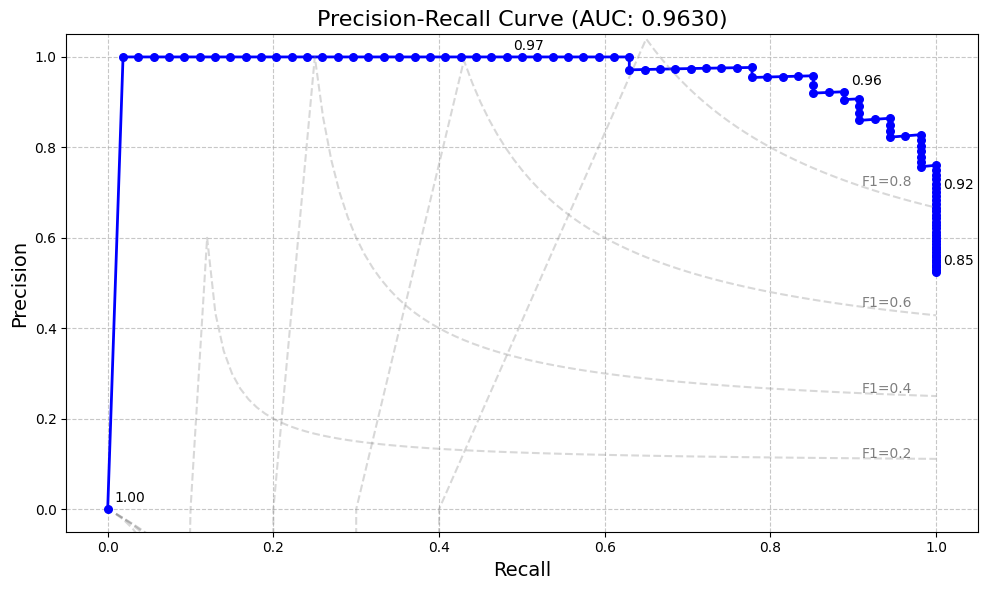

In [34]:
# Generate precision-recall curve
pr_curve = plot_precision_recall_curve(test_masks_gt, sorted_masks, sorted_similarities)

plt.show()


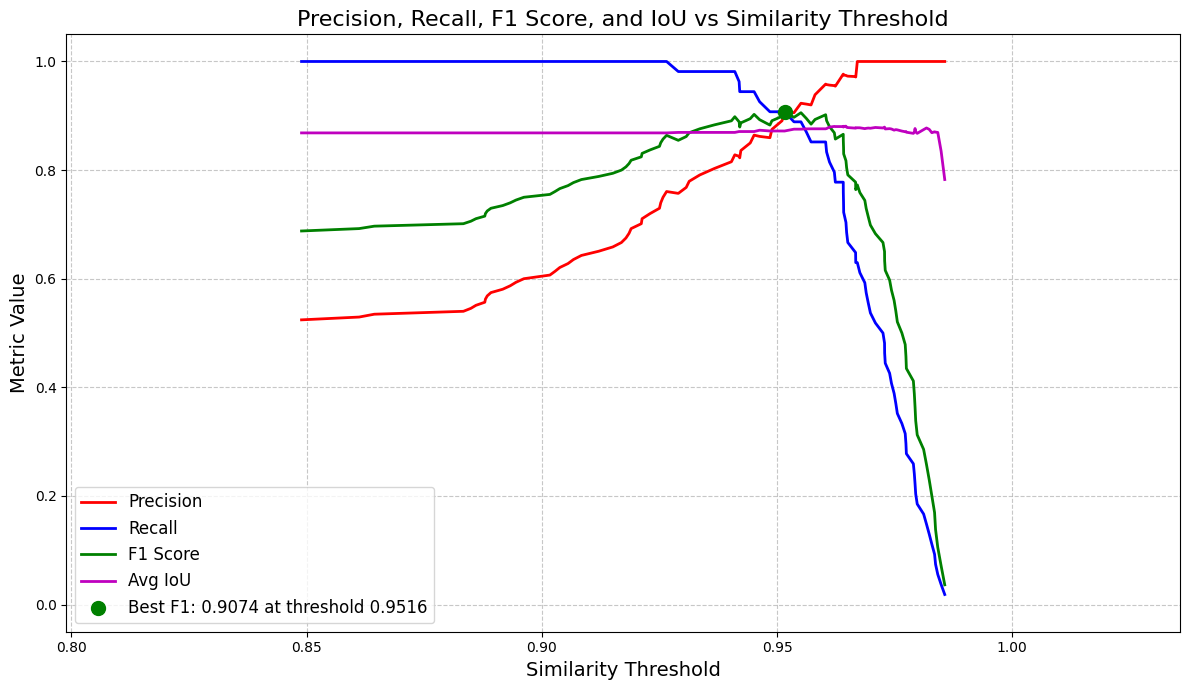

In [35]:
# Generate threshold vs metrics plot
threshold_plot = plot_threshold_vs_metrics(test_masks_gt, sorted_masks, sorted_similarities)
plt.show()

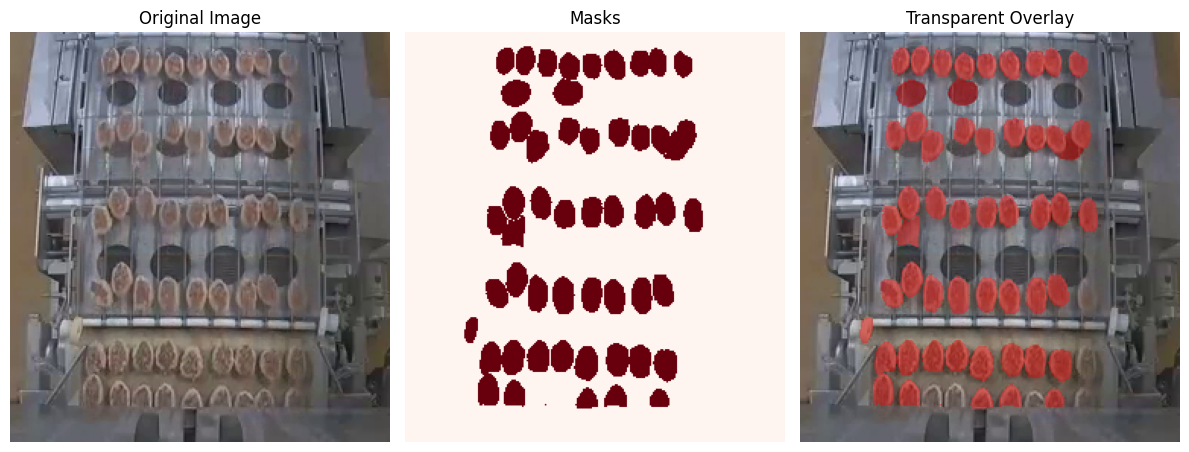

In [37]:
selected_masks = [mask for i, mask in enumerate(sorted_masks) if sorted_similarities[i] >= 0.9516]
visualize_masks(test_img, selected_masks)

In [38]:
results = evaluate_binary_masks(test_masks_gt, selected_masks)

print(f"Mask Detection Rate (Recall): {results['mask_recall']:.4f}")
print(f"Mask Precision: {results['mask_precision']:.4f}")
print(f"Detected {results['detected_masks']} out of {results['total_gt_masks']} GT masks")
print(f"Average IoU of detected masks: {results['avg_iou_detected']:.4f}")

Mask Detection Rate (Recall): 0.8889
Mask Precision: 0.9057
Detected 48 out of 54 GT masks
Average IoU of detected masks: 0.8754
